In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [68]:
import time
import ignite
import numpy as np
import sklearn.metrics
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms
from typing import List, Callable
import pickle
import tqdm
import pytorch_lightning as pl
import torchmetrics
import os.path
import cv2
import csv
import pandas as pd
#from google.colab import drive
from google.colab.patches import cv2_imshow
import fnmatch
from math import sqrt
from PIL import Image
import joblib
from torch_lr_finder import LRFinder
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.loggers import TensorBoardLogger
import tensorflow as tf

ERROR! Session/line number was not unique in database. History logging moved to new session 371


In [3]:
print(torch.cuda.is_available())
print(torch.__version__)

True
1.8.1+cu101


## Parameters

In [78]:
BATCH_SIZE = 32
EPOCHS = 12
LR = 1e-4
WD = 1e-4

ERROR! Session/line number was not unique in database. History logging moved to new session 374


## Data Classes

In [5]:
# Modificamos la carpeta 
print(os.getcwd())
print(os.listdir("Pruebas ImitAI"))
os.chdir("Pruebas ImitAI/1000 datos")
#os.chdir("../Prueba")
os.listdir()

/home/hodei.zia/ImitAI Project
['450 datos + Joint_velocities', 'Test_dataset', 'Train_dataset', 'lightning_logs', 'model_pytorch', 'model_pytorch_positions_015', 'Prueba', '400 datos + 10 Imagenes', '400 datos + 8 imagenes Depth + Joint_velocities', '400 datos + 8 imagenes Overhead + Joint_velocities', '400 datos + 6 imagenes + Joint_velocities', '400 datos + 10 Imagenes Bien', '1000 datos', '1000 Images New Dataset']


['Test_dataset',
 'Train_dataset',
 'MinMax_scaler.save',
 'lightning_logs',
 'model_pytorch_019',
 'MinMax_scaler_019.save',
 'model_pytorch_0124_notnorm',
 'model_pytorch_01848',
 'MinMax_scaler_4Images.save',
 'MinMax_scaler_no.save',
 'model_pytorch_00930',
 'model_pytorch_00927',
 'model_pytorch_00910']

In [6]:
def red_merge(carpeta_imagenes):
    
    length = len(fnmatch.filter(os.listdir(carpeta_imagenes + "Front_rgb/"), '*.png'))
    path = carpeta_imagenes + "Front_rgb/0.png"
    img = cv2.imread(path,1)
    aux = np.zeros(np.shape(img))
    
    for idx in range(length):
        path = carpeta_imagenes + "Front_rgb/" + str(idx) + ".png"

        #blurring and smoothin
        img=cv2.imread(path,1)

        hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
        lower_red = np.array([0,50,50])
        upper_red = np.array([10,255,255])

        mask = cv2.inRange(hsv, lower_red, upper_red)
        res = cv2.bitwise_and(img,img, mask= mask)

        aux = aux + res
    return aux
'''
res = red_merge("Train_dataset/")
cv2_imshow(res)'''

'\nres = red_merge("Train_dataset/")\ncv2_imshow(res)'

In [7]:
os.getcwd()

'/home/hodei.zia/ImitAI Project/Pruebas ImitAI/1000 datos'

/home/hodei.zia/ImitAI Project/Pruebas ImitAI/1000 datos


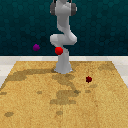

CPU times: user 223 ms, sys: 45 ms, total: 268 ms
Wall time: 535 ms


In [8]:
%%time
print(os.getcwd())
for i in range(1000):
    im = Image.open("Test_dataset/Front_rgb/"+str(i)+".png")
display(im)

/home/hodei.zia/ImitAI Project/Pruebas ImitAI/1000 datos


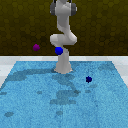

CPU times: user 598 ms, sys: 75.1 ms, total: 673 ms
Wall time: 686 ms


In [9]:
%%time
print(os.getcwd())
for i in range(1000):
    image = cv2.imread("Test_dataset/Front_rgb/"+str(i)+".png")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2_imshow(image)

### Normalizamos las acciones

In [6]:
print(os.getcwd())
print(os.listdir())
with open('Train_dataset/Train_Actions.csv') as f:
    lines = (line for line in f if not line.startswith('#'))
    x = np.loadtxt(lines, delimiter=',', skiprows=1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(x)
x_transformed = scaler.transform(x)
np.savetxt('Train_dataset/Train_Actions_Normalized.csv',x_transformed , delimiter=',', header="X1,X2,X3,X4,X5,X6,X7")

with open('Test_dataset/Test_Actions.csv') as f:
    lines = (line for line in f if not line.startswith('#'))
    x = np.loadtxt(lines, delimiter=',', skiprows=1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(x)
x_transformed = scaler.transform(x)
np.savetxt('Test_dataset/Test_Actions_Normalized.csv',x_transformed , delimiter=',', header="X1,X2,X3,X4,X5,X6,X7")

/home/hodei.zia/ImitAI Project/Pruebas ImitAI/1000 datos
['Test_dataset', 'Train_dataset', 'MinMax_scaler.save', 'lightning_logs', 'model_pytorch_019', 'MinMax_scaler_019.save', 'model_pytorch_0124_notnorm', 'model_pytorch_01848', 'MinMax_scaler_4Images.save', 'MinMax_scaler_no.save', 'model_pytorch_00930', 'model_pytorch_00927', 'model_pytorch_00910']


In [7]:
x_transformed.min(axis=0)

array([-1., -1., -1., -1., -1., -1., -1.])

In [8]:
scaler_filename = "MinMax_scaler.save"
scaler_to_save = MinMaxScaler(feature_range=(-1, 1))
joblib.dump(scaler_to_save, scaler_filename) 
scaler = joblib.load(scaler_filename) 

In [14]:
# Clases para mas de una imagen

class ObsActionGetter(object):
    """
    Generic class that return the image and the action given an index
    """
    def __init__(self, carpeta_imagenes, archivo_acciones):
        # TODO: get a list of all image files
        self.archivo_acciones = archivo_acciones
        self.carpeta_imagenes = carpeta_imagenes
        path, dirs, files = next(os.walk(self.carpeta_imagenes))
        self.image_files = list(range(len(files)))
        # TODO: get all made actions
        self.actions = []
        
    def __len__(self):
        return len(fnmatch.filter(os.listdir(self.carpeta_imagenes + "Front_rgb/"), '*.png'))
        
    def __getitem__(self, idx):
        path_1 = self.carpeta_imagenes + "Front_rgb/" + str(idx) + ".png"
        im1 = np.array(Image.open(path_1))
        
        if (idx == 0):
            im2 = np.array(Image.open(path_1))  

        else :
            path_2 = self.carpeta_imagenes + "Front_rgb/" + str(idx-1) + ".png"
            im2 = np.array(Image.open(path_2))  
        
        # TODO: get the action
        data = pd.read_csv(self.archivo_acciones, header = 0)
        action = np.float32(np.array(data.iloc[idx]))
        if (idx == 0):
            action_prev = np.array([0,0,0,0,0,0,0], dtype="float32")
        else:
            action_prev = np.float32(np.array(data.iloc[idx-1]))
            
        im_front = np.concatenate((im1, im2), axis=2)
        
        # Return both image and action
        return im_front, action, action_prev

class ObsActionDataset(Dataset):
    """
    PyTorch Dataset for getting the data. In this case, from ObsActionGetter object
    """
    def __init__(self, obs_action_getter: ObsActionGetter, transformations: List[Callable]):
        super(ObsActionDataset, self).__init__()
        self.obs_action_getter = obs_action_getter
        self.transformations = transformations
        
    def __len__(self):
        return len(self.obs_action_getter)
    
    def __getitem__(self, idx):
        im_front, action, action_prev = self.obs_action_getter[idx]
        for t in self.transformations:
            im_front = t(im_front)
        # Return both image and action
        return (im_front, action_prev), action
    
class MultiImage(nn.Module):
    def __init__(self, fe, clf):
        super(MultiImage, self).__init__()
        self.fe = fe
        self.clf = clf
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
    def forward(self, x):
        x1, x2 = x
        f1 = self.fe(x1)
        f = self.flatten(self.avg_pool(f1))
        f = torch.cat((f, x2), dim=1)
        return self.clf(f)

In [15]:
print(len(fnmatch.filter(os.listdir('Test_dataset/Front_rgb'), '*.png')))
print(len(fnmatch.filter(os.listdir('Test_dataset/Right_rgb'), '*')))
print(len(fnmatch.filter(os.listdir('Test_dataset/Left_rgb'), '*')))
print(len(fnmatch.filter(os.listdir('Test_dataset/Overhead_rgb'), '*')))
#print(len(fnmatch.filter(os.listdir('Test_dataset/Overhead_rgb'), '*')))
print(len(fnmatch.filter(os.listdir('Train_dataset/Front_rgb'), '*')))
print(len(fnmatch.filter(os.listdir('Train_dataset/Right_rgb'), '*')))
print(len(fnmatch.filter(os.listdir('Train_dataset/Left_rgb'), '*')))
print(len(fnmatch.filter(os.listdir('Train_dataset/Overhead_rgb'), '*')))
#print(len(fnmatch.filter(os.listdir('Train_dataset/Overhead_rgb'), '*')))

8974
8974
8974
8974
35857
35857
35857
35857


In [16]:
# Para mas de una imagen

# Create train Dataset.
# The ToTensor transform converts the image to Tensor in [0, 1] range and makes it channel first
# The Normalize transform normalizes the tensor using Imagenet stats

train_obs_action_getter = ObsActionGetter('Train_dataset/', 'Train_dataset/Train_Actions_Normalized.csv')
train_dataset = ObsActionDataset(train_obs_action_getter, 
                                [
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406, 0.485, 0.456, 0.406),
                                                         (0.229, 0.224, 0.225, 0.229, 0.224, 0.225))
                                ])

# Create test Dataset.
# The ToTensor transform converts the image to Tensor in [0, 1] range and makes it channel first
# The Normalize transform normalizes the tensor using Imagenet stats

test_obs_action_getter = ObsActionGetter('Test_dataset/', 'Test_dataset/Test_Actions_Normalized.csv')
test_dataset = ObsActionDataset(test_obs_action_getter, 
                                [
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406, 0.485, 0.456, 0.406),
                                                         (0.229, 0.224, 0.225, 0.229, 0.224, 0.225))
                                ])

In [28]:
%%time
# Create loaders (class that groups examples in batches)
# Uriz: train DataLoader should have shuffle to True
# Uriz: test DataLoader should have drop_last to False
# Uriz: use more workers to improve the training speed (load data in sever CPU threads). Otherwise we have a CPU -> GPU bottleneck
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=16)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=16)

print(len(train_dataset))
print(len(train_loader))
print(len(test_dataset))
print(len(test_loader))
'''
print("\nAccion Previa:", train_obs_action_getter[0][2])
print("\nAccion Actual:", train_obs_action_getter[0][1])
print("\nAccion Previa del siguiente:", train_obs_action_getter[1][2],"\n\n")
print("\nImagen Concatenada Actual:", train_obs_action_getter[0][0])
#print(train_dataset[1][0][0])'''

35857
1120
8974
281
CPU times: user 97.7 ms, sys: 37.2 ms, total: 135 ms
Wall time: 132 ms


'\nprint("\nAccion Previa:", train_obs_action_getter[0][2])\nprint("\nAccion Actual:", train_obs_action_getter[0][1])\nprint("\nAccion Previa del siguiente:", train_obs_action_getter[1][2],"\n\n")\nprint("\nImagen Concatenada Actual:", train_obs_action_getter[0][0])\n#print(train_dataset[1][0][0])'

In [29]:
it = iter(test_loader)
first = next(it)
second = next(it)
print(it)


## Model

We use a pretrained ResNet18 for now. We have to remove the classifier head because it is traiend for classification with 1000 classes. We add a custom head to make regression of 7 values

In [79]:
# To pretrain
model = models.resnet18(pretrained=False)

# Change the first convolution
new_conv = torch.nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model = list(model.children())[1:]
model = [new_conv] + model
model = torch.nn.Sequential(*model)

# Get only the feature extractor (remove avgpool and fc layers)
fe = nn.Sequential(*list(model.children())[:-2])

def freeze_all_but_bn(m):
    """
    Function that set a module as no trainable (not required grad) only if it is not a BatchNorm module
    Args:
        m: PyTorch Module
    """
    if not isinstance(m, torch.nn.modules.batchnorm._BatchNorm):
        if hasattr(m, 'weight') and m.weight is not None:
            m.weight.requires_grad_(False)
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.requires_grad_(False)
            
def unfreeze_all_but_bn(m):
    """
    Function that set a module as no trainable (not required grad) only if it is not a BatchNorm module
    Args:
        m: PyTorch Module
    """
    if not isinstance(m, torch.nn.modules.batchnorm._BatchNorm):
        if hasattr(m, 'weight') and m.weight is not None:
            m.weight.requires_grad_(True)
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.requires_grad_(True)
            
# Freeze all but BatchNorm layers of feature extractor
# Uriz: if we use the "normal" ResNet use the pretained version and freeze all but BN
#       only set all trainiable when we change the fitst convolution layer to accept images of 6 dimensions
#       if the ResNet is pretrained and freezed the training accuracy is maintained (or increased) and the train time is dreceased
fe.apply(freeze_all_but_bn) # Solo usar si no se preentrena la red

# Create custom head
head_clf = nn.Sequential(
    nn.BatchNorm1d(512+7),
    nn.Dropout(0.25),
    nn.Linear(512+7, 512), 
    nn.ReLU(),
    nn.BatchNorm1d(512),   
    nn.Dropout(0.25),
    nn.Linear(512, 7)
)

# Rebuild the model
model = MultiImage(fe, head_clf)

## Train Model

In [80]:
# Create trainable class with Pytorch Lightinng
class LitModel(pl.LightningModule):
    def __init__(self, model, loss_function, total_iterations, lr):
        """
        Constructor of the trainable class
        Args:
            model: PyTorch model
            loss_function: The loss function to use
            total_iterations: The total number of iterations for training (num_batches * num_epochs). Used for
                                LR Schedule
            lr: the max_lr to use for the OneCycleLR policy
        """
        super().__init__()
        # Store params
        self.model = model
        self.loss_function = loss_function
        self.total_iterations = total_iterations
        self.lr = lr
        # For measure the MSE
        self.train_mse = torchmetrics.MeanSquaredError()
        self.valid_mse = torchmetrics.MeanSquaredError()

    def forward(self, x):
        # Forward method
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        prediction = self(x)
        loss = self.loss_function(prediction, y)
        # Get MSE
        self.train_mse(prediction, y)
        # Log loss and MSE
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_mse', self.train_mse, on_step=True, on_epoch=False, prog_bar=True)
        #for i in range(7):
        #    plt.plot(prediction.cpu().detach().numpy()[:,i], label='prediction')
        #    plt.plot(y.cpu().detach().numpy()[:,i], label='target')
        #    plt.show()
        # Return Loss for backward
        return loss

    def training_epoch_end(self, outs):
        # log epoch metric
        self.log('train_acc_epoch', self.train_mse.compute())

    def validation_step(self, batch, batch_idx):
        x, y = batch
        prediction = self(x)
        loss = self.loss_function(prediction, y)
        # Get MSE
        self.valid_mse(prediction, y)
        # Log loss and MSE
        self.log('valid_loss', loss, prog_bar=True)
        self.log('val_mse', self.valid_mse, on_step=True, on_epoch=False, prog_bar=True)
        return loss

    def validation_epoch_end(self, outs):
        # log epoch metric
        self.log('val_acc_epoch', self.valid_mse.compute())

    def configure_optimizers(self):
        # Get Adam optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        # Set OneCycleLR policy
        lr_scheduler = {
            'scheduler': torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.lr,
                                                             total_steps=self.total_iterations),
            'interval': 'step', 'frequency': 1, 'name': 'lr_logger'
        }
        return [optimizer], [lr_scheduler]

In [81]:
class CallbackClass(Callback):
    def __init__(self, what="epochs", verbose=True):
        self.what = what
        self.verbose = verbose
        self.state = {"epochs": 0}
        
    @property
    def state_key(self):
        # note: we do not include `verbose` here on purpose
        return self._generate_state_key(what=self.what)

    def on_train_epoch_end(self, *args, **kwargs):
        e = 0
        if self.what == "epochs":
            self.state["epochs"] += 1
            
        if self.state["epochs"] == 2:
            for param in pl_model.parameters():
                param.requires_grad = True # Unfreeze
        
        for name, param in pl_model.named_parameters():
            if param.requires_grad:
                e = e+1

    def load_state_dict(self, state_dict):
        self.state.update(state_dict)

    def state_dict(self):
        return self.state.copy()

## Find the best LR and Train the Model

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.42E-01


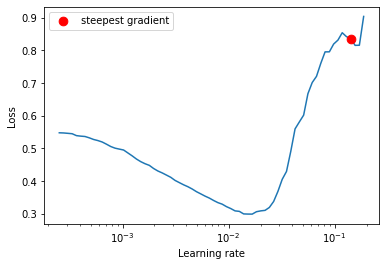

0.1417474162926805
0.01


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 11.5 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
281 K     Trainable params
11.2 M    Non-trainable params
11.5 M    Total params
45.831    Total estimated model params size (MB)


0.01


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [82]:
# Loss function
criterion = nn.MSELoss()

# We catch the optimizer of our lit_model
# optimizer, lr_scheduler = pl_model.configure_optimizers()
optimizer = optim.Adam(model.parameters(), lr=LR)

# Learning State Finder
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=1, num_iter=100, step_mode="exp")

# Create trainer class
try:
    print(lr_finder.plot()[1])
except:
    print("AxisPlot Error")

BEST_LR = float(input())
print(BEST_LR)

# Number of iterations for LR Schedule
ITERATIONS_PER_EPOCH = len(train_loader)

logger = TensorBoardLogger("/home/hodei.zia/ImitAI Project/tb_logs", name="my_model")

# Create PytorchLighting model for training
pl_model = LitModel(model, criterion, total_iterations=ITERATIONS_PER_EPOCH * EPOCHS, lr=BEST_LR)

NUM_GPUS = 1 if torch.cuda.is_available() else 0

# Create trainer class
#trainer = pl.Trainer(auto_lr_find=True, min_epochs=eps, max_epochs=eps,
                     #log_every_n_steps=1, gpus=NUM_GPUS, callbacks=[CallbackClass(what="epochs")], logger=logger)
trainer = pl.Trainer(auto_lr_find=True, min_epochs=EPOCHS, max_epochs=EPOCHS,
                     log_every_n_steps=1, gpus=NUM_GPUS, callbacks=[CallbackClass(what="epochs")], logger=logger)

# Train the model
trainer.fit(pl_model, train_loader, val_dataloaders=test_loader)

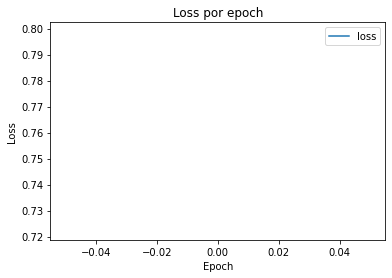

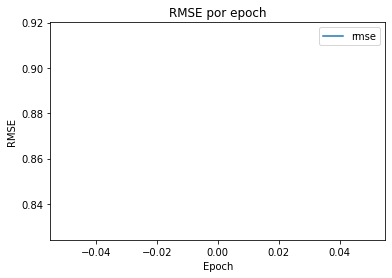

[0.872114464474072]


In [121]:
NUMBER = num
num = num + 1
PATH_TB = os.listdir("../../tb_logs/my_model/version_" + str(NUMBER))[1]
PATH = "/home/hodei.zia/ImitAI Project/tb_logs/my_model/version_" + str(NUMBER) + "/"

errores=[]
#path_to_events_file="/home/hodei.zia/ImitAI Project/tb_logs/my_model/version_0/events.out.tfevents.1649153055.gpu02.net.unavarra.es.251977.19"
for e in tf.compat.v1.train.summary_iterator(path_to_events_file):
    for v in e.summary.value:
        if v.tag == 'train_loss_epoch':
            errores.append(v.simple_value)
plt.plot(errores, label='loss')
plt.title("Loss por epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

rmse=[]
for e in tf.compat.v1.train.summary_iterator(path_to_events_file):
    for v in e.summary.value:
        if v.tag == 'train_acc_epoch':
            rmse.append(sqrt(v.simple_value))
plt.plot(rmse, label='rmse')
plt.title("RMSE por epoch")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.show()
print(rmse)

## Make Predictions and Save the Model

In [92]:
# Put model on eval mode so we change the BatchNorm and Dropout layers behaviour
model = model.eval()
# Set device ("cuda" or GPU if cuda is installed, otherwise in "cpu")
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# To concatenate predictions and labels
predictions = None
labels = None
# Surround all for not computing gradients
with torch.no_grad():
    # Iterate over test dataset
    for x, y in tqdm.notebook.tqdm(test_loader):
        # Move to device
        x1, x2 = x
        x1 = x1.to(device)
        x2 = x2.to(device)
        # Predict
        o = model((x1, x2))
        # Concatenate
        if predictions is None:
            predictions = o
        else:
            predictions = torch.cat((predictions, o), axis=0)

        if labels is None:
            labels = y
        else:
            labels = torch.cat((labels, y), axis=0)
    
    # Move predictions to CPU and to numpy
    predictions = predictions.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

mse = sklearn.metrics.mean_squared_error(labels, predictions)
rmse = sqrt(mse)
print("El valor del error cudratico medios (MSE) es igual a " + str(mse))
print("El valor RMSE es igual a " + str(rmse))

  0%|          | 0/281 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 0.0074465806
El valor RMSE es igual a 0.08629357198810265


In [93]:
# Error promedio de cada una de las articulaciones
joint_error = np.zeros(7)
minimo = np.zeros(7)
maximo = np.zeros(7)
for i in range(7):
    joint_error[i] = sqrt(sklearn.metrics.mean_squared_error(predictions[:, i], labels[:, i]))
    minimo[i] = min(labels[:, i])
    maximo[i] = max(labels[:, i])
    
print(joint_error)

for i in range(7):
    print("Articulacion " + str(i) + " [" + str(round(minimo[i], 2)) + " - " + str(round(maximo[i], 2)) + "] " +
          str(round(abs(round(minimo[i], 2) - round(maximo[i], 2)),2))
          , str(round(joint_error[i]*100/round(abs(round(minimo[i], 2) - round(maximo[i], 2)),2),2)) + "%")

[0.06749031 0.07458057 0.0751323  0.05467222 0.14104705 0.06694482
 0.09486354]
Articulacion 0 [-1.0 - 1.0] 2.0 3.37%
Articulacion 1 [-1.0 - 1.0] 2.0 3.73%
Articulacion 2 [-1.0 - 1.0] 2.0 3.76%
Articulacion 3 [-1.0 - 1.0] 2.0 2.73%
Articulacion 4 [-1.0 - 1.0] 2.0 7.05%
Articulacion 5 [-1.0 - 1.0] 2.0 3.35%
Articulacion 6 [-1.0 - 1.0] 2.0 4.74%


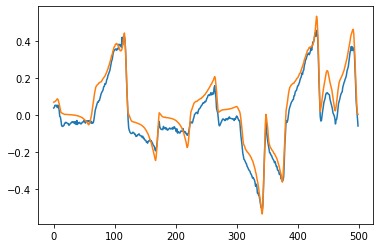

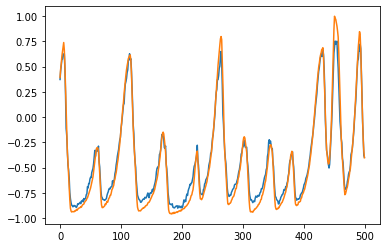

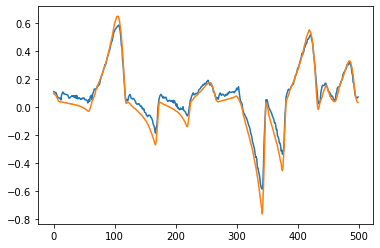

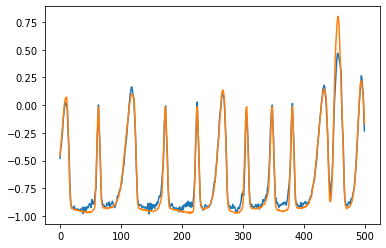

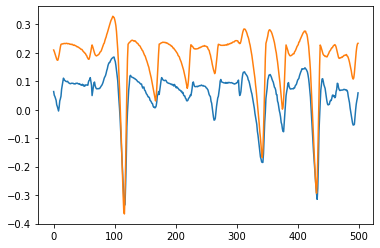

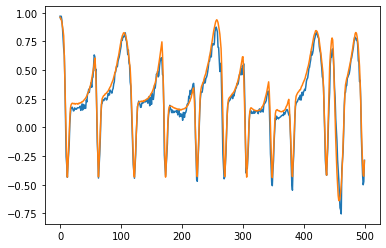

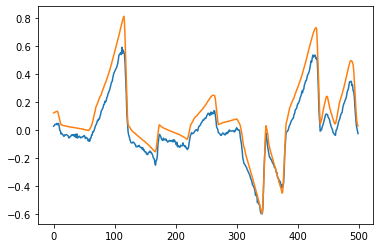

In [94]:
import matplotlib.pyplot as plt

for i in range(7):
    plt.plot(predictions[500:1000, i], label='prediction')
    plt.plot(labels[500:1000, i], label='target')
    plt.show()

In [95]:
torch.save(model, 'model_pytorch_0086')
model = torch.load('model_pytorch_0086')
model.eval()

MultiImage(
  (fe): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

## Bucle to obtain all the info for differents Epochs

In [122]:
RMSE_List = []
Model_List = []
Prediction_List = []
Label_List = []
LR_List = []
Loss_List = []

ERROR! Session/line number was not unique in database. History logging moved to new session 381


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.86E-04


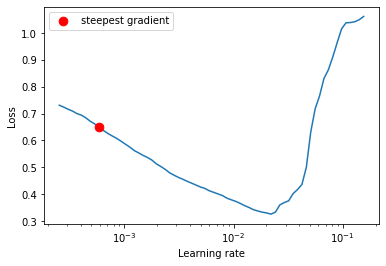

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 11.5 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
281 K     Trainable params
11.2 M    Non-trainable params
11.5 M    Total params
45.831    Total estimated model params size (MB)


0.0005857020818056665
EPOCH NUMERO: 8


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

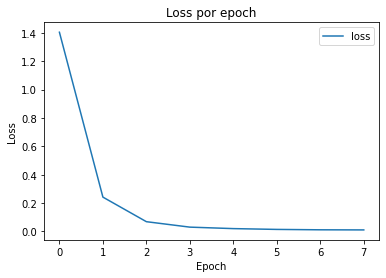

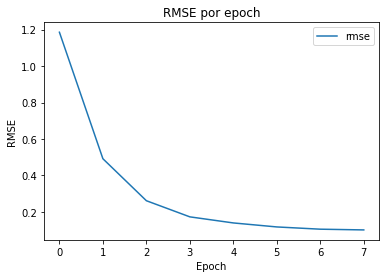

[1.1853415297220207, 0.4916559406770051, 0.2614169159541362, 0.17292736568059836, 0.1396004854583736, 0.11764520034095653, 0.10531107277568097, 0.10132772563246802]


  0%|          | 0/281 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 0.009270291
El valor RMSE es igual a 0.0962823495981607
[0.0962823495981607]


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.29E-01


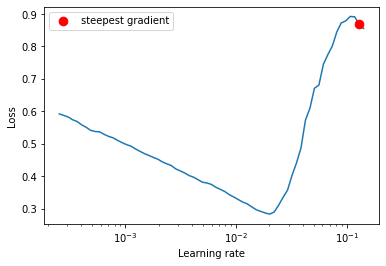

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 11.5 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
281 K     Trainable params
11.2 M    Non-trainable params
11.5 M    Total params
45.831    Total estimated model params size (MB)


0.12915496650148842
EPOCH NUMERO: 9


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

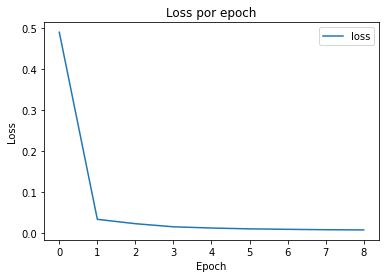

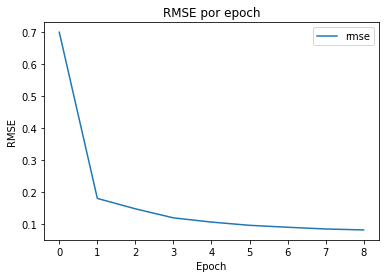

[0.6996772158140822, 0.18064535920527408, 0.1481764719357696, 0.11994018539157716, 0.10674519250382994, 0.09665017689071015, 0.09060704920829978, 0.08518560892120554, 0.0822708994604616]


  0%|          | 0/281 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 0.008212532
El valor RMSE es igual a 0.09062302089865004
[0.0962823495981607, 0.09062302089865004]


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.29E-01


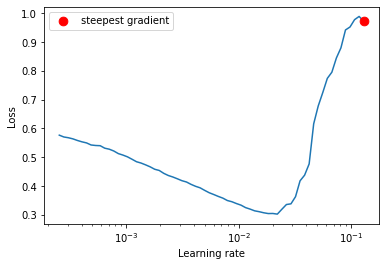

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 11.5 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
281 K     Trainable params
11.2 M    Non-trainable params
11.5 M    Total params
45.831    Total estimated model params size (MB)


0.12915496650148842
EPOCH NUMERO: 10


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

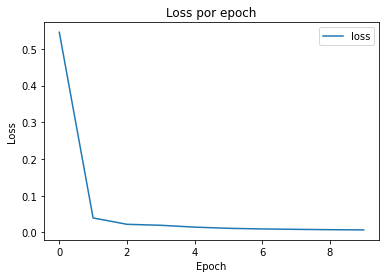

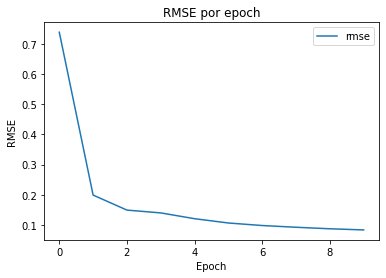

[0.7385537588172482, 0.199039902534783, 0.1493110488619093, 0.1399963220577262, 0.12080467621823522, 0.10656547326193795, 0.0982027213453253, 0.09243310442539746, 0.08741558763123233, 0.08363906432084822]


  0%|          | 0/281 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 0.007675376
El valor RMSE es igual a 0.08760922205683552
[0.0962823495981607, 0.09062302089865004, 0.08760922205683552]


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.48E-03


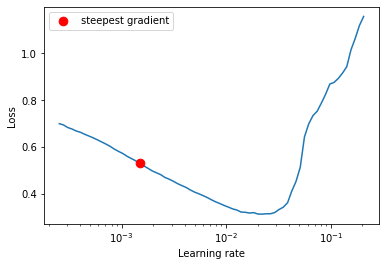

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 11.5 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
281 K     Trainable params
11.2 M    Non-trainable params
11.5 M    Total params
45.831    Total estimated model params size (MB)


0.001484968262254465
EPOCH NUMERO: 11


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

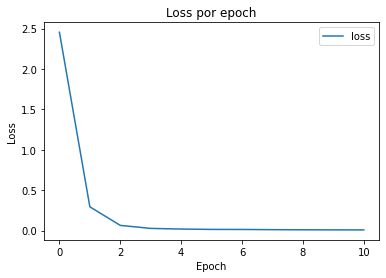

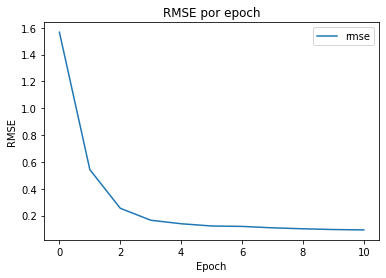

[1.5667957763363685, 0.5426237533421444, 0.2543614928012504, 0.16522949563255296, 0.13901439193576615, 0.12230197667736531, 0.1192418239295294, 0.1086693591423797, 0.10151798850125421, 0.09588289406821991, 0.09304537320306323]


  0%|          | 0/281 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 0.008669201
El valor RMSE es igual a 0.09310854571223304
[0.0962823495981607, 0.09062302089865004, 0.08760922205683552, 0.09310854571223304]


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.96E-03


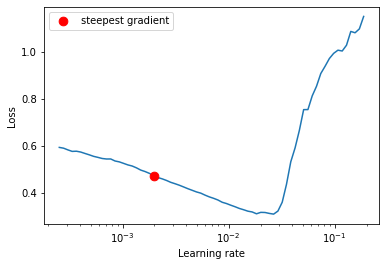

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 11.5 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
281 K     Trainable params
11.2 M    Non-trainable params
11.5 M    Total params
45.831    Total estimated model params size (MB)


0.0019630406500402713
EPOCH NUMERO: 12


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

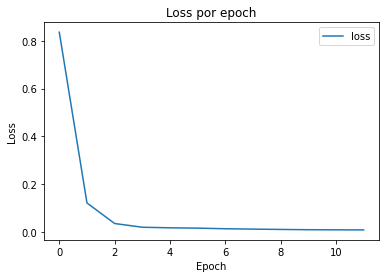

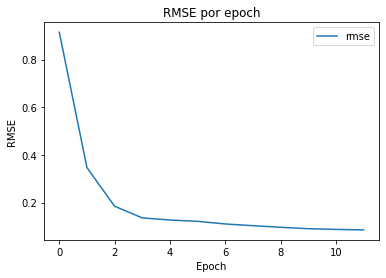

[0.9142855836610616, 0.3469037581026889, 0.18487489384744213, 0.13615745036883306, 0.12727227808900934, 0.12166731880233127, 0.11060659931729318, 0.10342353197070901, 0.09665544282956659, 0.09075719937457861, 0.08780763734813986, 0.08569920620439367]


  0%|          | 0/281 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 0.00730051
El valor RMSE es igual a 0.08544302236706057
[0.0962823495981607, 0.09062302089865004, 0.08760922205683552, 0.09310854571223304, 0.08544302236706057]


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.29E-01


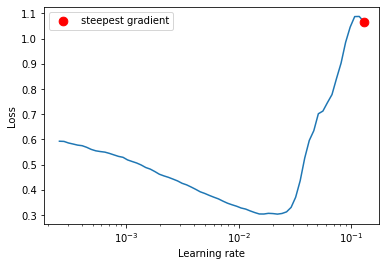

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 11.5 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
281 K     Trainable params
11.2 M    Non-trainable params
11.5 M    Total params
45.831    Total estimated model params size (MB)


0.12915496650148842
EPOCH NUMERO: 13


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

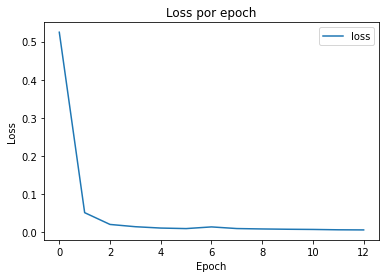

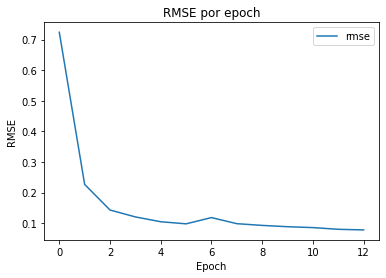

[0.7242301092316629, 0.226466479178343, 0.1427778908678185, 0.12015176678517175, 0.10439970255248496, 0.09754762807473193, 0.11799188949051262, 0.09806514015132599, 0.09241374709633171, 0.08813354512476476, 0.0852464149347385, 0.07966595503386648, 0.07765290853249977]


  0%|          | 0/281 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 0.01959735
El valor RMSE es igual a 0.13999053428146763
[0.0962823495981607, 0.09062302089865004, 0.08760922205683552, 0.09310854571223304, 0.08544302236706057, 0.13999053428146763]


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.18E-01


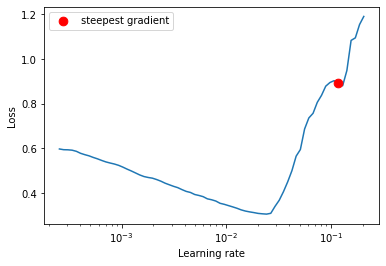

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 11.5 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
281 K     Trainable params
11.2 M    Non-trainable params
11.5 M    Total params
45.831    Total estimated model params size (MB)


0.11768119524349979
EPOCH NUMERO: 14


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

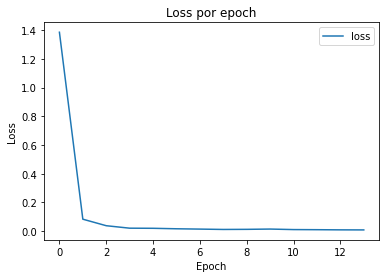

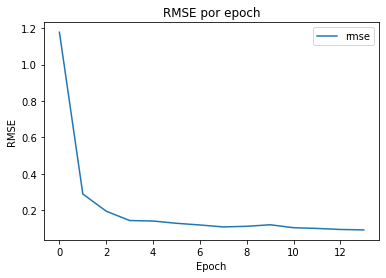

[1.1772855343060127, 0.288169409087064, 0.19373926740576472, 0.14263845499865813, 0.13980204796890702, 0.12730450054575188, 0.11806653466860569, 0.10733735487488207, 0.11075469035593992, 0.1191798208205316, 0.10309925101064348, 0.0991122143155437, 0.09335428906397737, 0.09091524576930103]


  0%|          | 0/281 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 0.007762257
El valor RMSE es igual a 0.08810367194246017
[0.0962823495981607, 0.09062302089865004, 0.08760922205683552, 0.09310854571223304, 0.08544302236706057, 0.13999053428146763, 0.08810367194246017]


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.18E-01


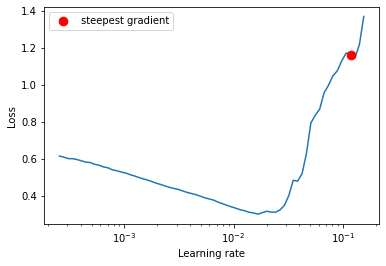

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 11.5 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
281 K     Trainable params
11.2 M    Non-trainable params
11.5 M    Total params
45.831    Total estimated model params size (MB)


0.11768119524349979
EPOCH NUMERO: 15


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

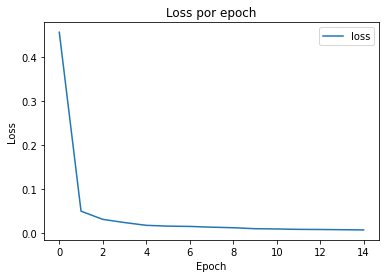

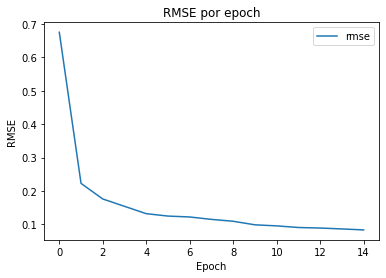

[0.6757229906668961, 0.22250999700129492, 0.1757365752776278, 0.15375132629938973, 0.13169594148656627, 0.12448925862908228, 0.1217915632975004, 0.11456619526475162, 0.10892606033062353, 0.09826060685537333, 0.09510394754241791, 0.09022428943367972, 0.08860504871388757, 0.0859317127359877, 0.08299037806357155]


  0%|          | 0/281 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 0.0075344355
El valor RMSE es igual a 0.08680112605581994
[0.0962823495981607, 0.09062302089865004, 0.08760922205683552, 0.09310854571223304, 0.08544302236706057, 0.13999053428146763, 0.08810367194246017, 0.08680112605581994]


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.42E-01


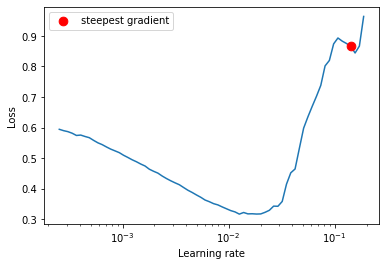

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 11.5 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
281 K     Trainable params
11.2 M    Non-trainable params
11.5 M    Total params
45.831    Total estimated model params size (MB)


0.1417474162926805
EPOCH NUMERO: 16


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

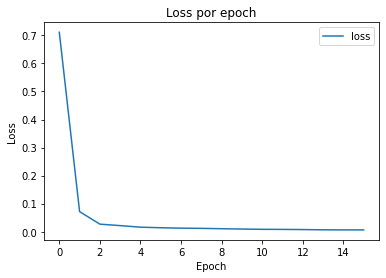

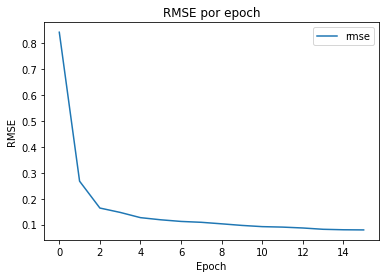

[0.8434044872266786, 0.2676923327111058, 0.1639029146787871, 0.1470137820574803, 0.12679100689380482, 0.11848050299284874, 0.11214439728945562, 0.10876264473967177, 0.10290358101933934, 0.09675104705880982, 0.09202648422517944, 0.09022719511556322, 0.08682168112092895, 0.08178085474039751, 0.07993901486132071, 0.07935116969130883]


  0%|          | 0/281 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 0.008948286
El valor RMSE es igual a 0.09459538077501002
[0.0962823495981607, 0.09062302089865004, 0.08760922205683552, 0.09310854571223304, 0.08544302236706057, 0.13999053428146763, 0.08810367194246017, 0.08680112605581994, 0.09459538077501002]


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.96E-03


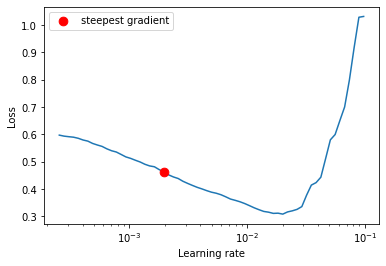

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 11.5 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
281 K     Trainable params
11.2 M    Non-trainable params
11.5 M    Total params
45.831    Total estimated model params size (MB)


0.0019630406500402713
EPOCH NUMERO: 17


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

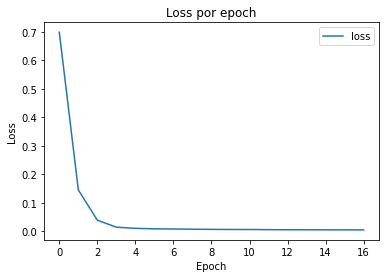

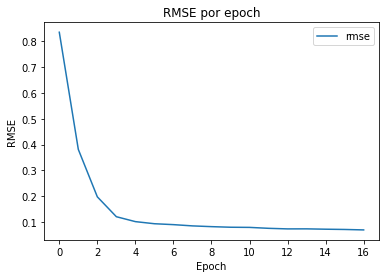

[0.8357577620889544, 0.3811203478187993, 0.1970486722620245, 0.11997354261106725, 0.10090248057719542, 0.09274048973080315, 0.08921685437261334, 0.08435466276217887, 0.08143408009490977, 0.07914083589071963, 0.07853677237099393, 0.07493066041092247, 0.07269490492991923, 0.07285230817745558, 0.0714759695343512, 0.07049332321898383, 0.06872976639332652]


  0%|          | 0/281 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 0.010310925
El valor RMSE es igual a 0.10154272308730786
[0.0962823495981607, 0.09062302089865004, 0.08760922205683552, 0.09310854571223304, 0.08544302236706057, 0.13999053428146763, 0.08810367194246017, 0.08680112605581994, 0.09459538077501002, 0.10154272308730786]


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.13E-03


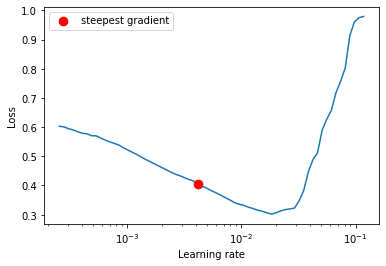

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 11.5 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
281 K     Trainable params
11.2 M    Non-trainable params
11.5 M    Total params
45.831    Total estimated model params size (MB)


0.004132012400115337
EPOCH NUMERO: 18


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

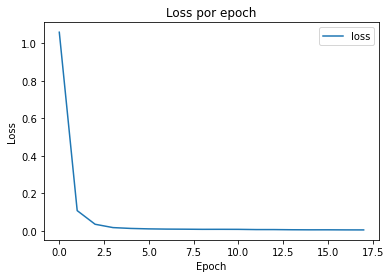

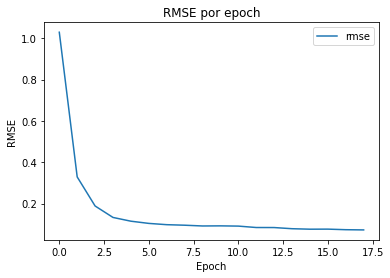

[1.0291805310158457, 0.3288176922492437, 0.1881950628312318, 0.1327241435382059, 0.11458051381832587, 0.10391009492142049, 0.0977130343330475, 0.09514812185778712, 0.09144855421008226, 0.09200503204962979, 0.09082424503959494, 0.08398857217103771, 0.08381185721731227, 0.07819978293843187, 0.07586038306928725, 0.07618609625768646, 0.07341828475319903, 0.07236679187037663]


  0%|          | 0/281 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 0.010609426
El valor RMSE es igual a 0.10300206601978144
[0.0962823495981607, 0.09062302089865004, 0.08760922205683552, 0.09310854571223304, 0.08544302236706057, 0.13999053428146763, 0.08810367194246017, 0.08680112605581994, 0.09459538077501002, 0.10154272308730786, 0.10300206601978144]


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.56E-01


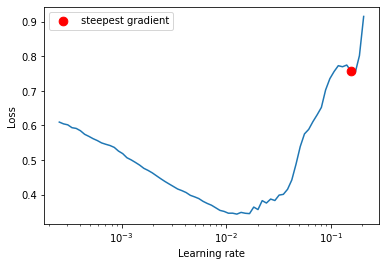

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 11.5 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
281 K     Trainable params
11.2 M    Non-trainable params
11.5 M    Total params
45.831    Total estimated model params size (MB)


0.15556761439304725
EPOCH NUMERO: 19


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

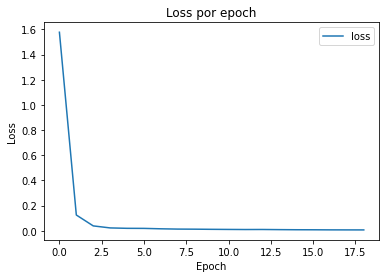

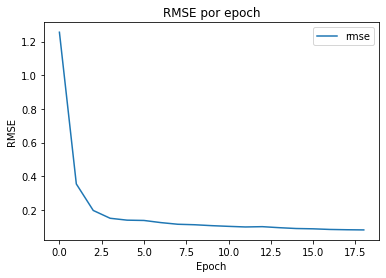

[1.255942761632524, 0.35341517459706134, 0.19580239844665104, 0.1492981991292462, 0.1380875324335213, 0.13628571596680983, 0.1235084014688874, 0.11370789409484237, 0.11077038441303329, 0.10538794813156999, 0.10122499875468835, 0.09757019065686219, 0.09936977535434748, 0.0933099841505616, 0.08834299917698146, 0.08655892100922818, 0.0827658267570544, 0.08105126626481213, 0.08001869019654582]


  0%|          | 0/281 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 0.0094787
El valor RMSE es igual a 0.09735861722130579
[0.0962823495981607, 0.09062302089865004, 0.08760922205683552, 0.09310854571223304, 0.08544302236706057, 0.13999053428146763, 0.08810367194246017, 0.08680112605581994, 0.09459538077501002, 0.10154272308730786, 0.10300206601978144, 0.09735861722130579]


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.29E-01


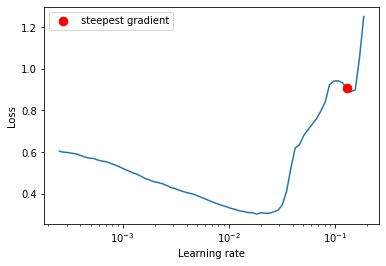

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 11.5 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
281 K     Trainable params
11.2 M    Non-trainable params
11.5 M    Total params
45.831    Total estimated model params size (MB)


0.12915496650148842
EPOCH NUMERO: 20


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

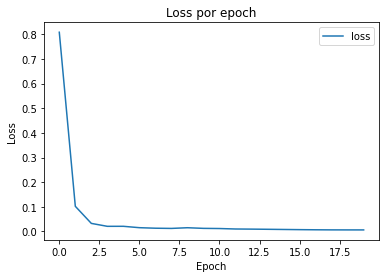

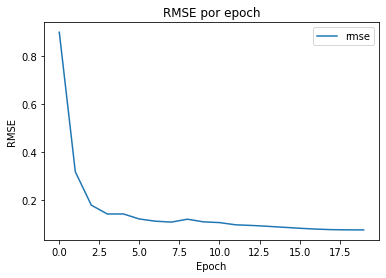

[0.899251353636405, 0.3191115031034824, 0.18006441763386713, 0.14332412837332542, 0.14362958653914581, 0.12258619020574685, 0.11352166200482845, 0.10972318830153668, 0.12177391689835387, 0.11073029772191885, 0.10767476052821578, 0.09849351072810644, 0.09577333055087739, 0.09222021795227164, 0.08818472558411508, 0.08415024479249889, 0.08066882068649113, 0.0783260648950367, 0.07745235673563027, 0.07719845297356932]


  0%|          | 0/281 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 0.0076088593
El valor RMSE es igual a 0.08722877583768453
[0.0962823495981607, 0.09062302089865004, 0.08760922205683552, 0.09310854571223304, 0.08544302236706057, 0.13999053428146763, 0.08810367194246017, 0.08680112605581994, 0.09459538077501002, 0.10154272308730786, 0.10300206601978144, 0.09735861722130579, 0.08722877583768453]


In [123]:
Epoch_List = [8,9,10,11,12,13,14,15,16,17,18,19,20]
num = 0
for eps in Epoch_List:
    
    # 1 - Se genera la red
    
    # To pretrain
    model = models.resnet18(pretrained=False)

    # Change the first convolution
    new_conv = torch.nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model = list(model.children())[1:]
    model = [new_conv] + model
    model = torch.nn.Sequential(*model)

    # Get only the feature extractor (remove avgpool and fc layers)
    fe = nn.Sequential(*list(model.children())[:-2])

    fe.apply(freeze_all_but_bn) # Solo usar si no se preentrena la red

    # Create custom head
    head_clf = nn.Sequential(
    nn.BatchNorm1d(512+7),
    nn.Dropout(0.25),
    nn.Linear(512+7, 512), 
    nn.ReLU(),
    nn.BatchNorm1d(512),   
    nn.Dropout(0.25),
    nn.Linear(512, 7)
    )

    # Rebuild the model
    model = MultiImage(fe, head_clf)
    
    # 2 - Se busca el mejor Learning Rate a aplicar como maximo posible
    
    # Loss function
    criterion = nn.MSELoss()

    # We catch the optimizer of our lit_model
    # optimizer, lr_scheduler = pl_model.configure_optimizers()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # Learning State Finder
    lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
    lr_finder.range_test(train_loader, end_lr=1, num_iter=100, step_mode="exp")

    # Create trainer class
    try:
        BEST_LR = lr_finder.plot()[1]
    except:
        BEST_LR = 5.0E-03
    print(BEST_LR)
    
    if BEST_LR > 0.09:
        BEST_LR = 5.0E-03

    # 3 - Se prepara el Trainer y se entrena con el modelo LitModel
    
    # Number of iterations for LR Schedule
    ITERATIONS_PER_EPOCH = len(train_loader)
    
    logger = TensorBoardLogger("/home/hodei.zia/ImitAI Project/tb_logs", name="my_model")

    # Create PytorchLighting model for training
    pl_model = LitModel(model, criterion, total_iterations=ITERATIONS_PER_EPOCH * eps, lr=BEST_LR)

    NUM_GPUS = 1 if torch.cuda.is_available() else 0
    
    # Create trainer class
    trainer = pl.Trainer(auto_lr_find=True, min_epochs=eps, max_epochs=eps,
                         log_every_n_steps=1, gpus=NUM_GPUS, callbacks=[CallbackClass(what="epochs")], logger=logger)

    print("EPOCH NUMERO: " + str(eps))
    
    # Train the model
    trainer.fit(pl_model, train_loader, val_dataloaders=test_loader)
    
    NUMBER = num
    num = num + 1
    PATH_TB = os.listdir("../../tb_logs/my_model/version_" + str(NUMBER))[1]
    PATH = "/home/hodei.zia/ImitAI Project/tb_logs/my_model/version_" + str(NUMBER) + "/"
    path_to_events_file = PATH + PATH_TB

    errores=[]
    #path_to_events_file="/home/hodei.zia/ImitAI Project/tb_logs/my_model/version_0/events.out.tfevents.1649153055.gpu02.net.unavarra.es.251977.19"
    for e in tf.compat.v1.train.summary_iterator(path_to_events_file):
        for v in e.summary.value:
            if v.tag == 'train_loss_epoch':
                errores.append(v.simple_value)
    plt.plot(errores, label='loss')
    plt.title("Loss por epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    rmse=[]
    for e in tf.compat.v1.train.summary_iterator(path_to_events_file):
        for v in e.summary.value:
            if v.tag == 'train_acc_epoch':
                rmse.append(sqrt(v.simple_value))
    plt.plot(rmse, label='rmse')
    plt.title("RMSE por epoch")
    plt.xlabel("Epoch")
    plt.ylabel("RMSE")
    plt.legend()
    plt.show()
    print(rmse)
    
    # 4 - Se predice el resultado
    
    # Put model on eval mode so we change the BatchNorm and Dropout layers behaviour
    model = model.eval()
    # Set device ("cuda" or GPU if cuda is installed, otherwise in "cpu")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    # To concatenate predictions and labels
    predictions = None
    labels = None
    # Surround all for not computing gradients
    with torch.no_grad():
        # Iterate over test dataset
        for x, y in tqdm.notebook.tqdm(test_loader):
            # Move to device
            x1, x2 = x
            x1 = x1.to(device)
            x2 = x2.to(device)
            # Predict
            o = model((x1, x2))
            # Concatenate
            if predictions is None:
                predictions = o
            else:
                predictions = torch.cat((predictions, o), axis=0)

            if labels is None:
                labels = y
            else:
                labels = torch.cat((labels, y), axis=0)

        # Move predictions to CPU and to numpy
        predictions = predictions.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()

    mse = sklearn.metrics.mean_squared_error(labels, predictions)
    rmse = sqrt(mse)
    
    print("El valor del error cudratico medios (MSE) es igual a " + str(mse))
    print("El valor RMSE es igual a " + str(rmse))

    # 5 - Se guardan los resultados 
    
    RMSE_List.append(rmse)
    Model_List.append(model)
    Prediction_List.append(predictions)
    Label_List.append(labels)
    LR_List.append(BEST_LR)
    #Loss_List.append(lr_finder.history['loss'][lr_finder.history['lr'].index(BEST_LR)])
    
    print(RMSE_List)

In [48]:
Epoch_List[(RMSE_List.index(min(RMSE_List)))]

30

BEST RMSE: 0.08544302236706057 in Epoch 12 with Batch Size = 32 
LR = 0.0019630406500402713


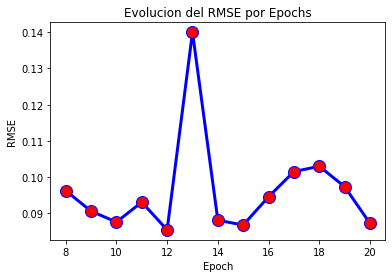

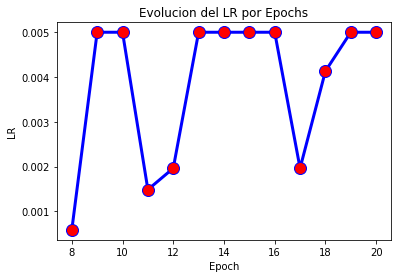

In [124]:
Epoch_List = [8,9,10,11,12,13,14,15,16,17,18,19,20]

print("BEST RMSE: " + str(min(RMSE_List)) + " in Epoch " + 
      str(Epoch_List[(RMSE_List.index(min(RMSE_List)))]) + " with Batch Size = " + str(BATCH_SIZE) + " \nLR = " + 
      str(LR_List[(RMSE_List.index(min(RMSE_List)))]))

# Plot de RMSE-Epoch
plt.plot(Epoch_List, RMSE_List, color='blue', linewidth = 3, marker='o', markerfacecolor='red', markersize=12)
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Evolucion del RMSE por Epochs')
plt.show()

# Plot del LR-Epoch
plt.plot(Epoch_List, LR_List, color='blue', linewidth = 3, marker='o', markerfacecolor='red', markersize=12)
plt.xlabel('Epoch')
plt.ylabel('LR')
plt.title('Evolucion del LR por Epochs')
plt.show()

0.08544302236706057
[0.07928155 0.06538091 0.07561524 0.0420063  0.13654668 0.06917365
 0.09813841]
Articulacion 0 [-1.0 - 1.0] 2.0 3.96%
Articulacion 1 [-1.0 - 1.0] 2.0 3.27%
Articulacion 2 [-1.0 - 1.0] 2.0 3.78%
Articulacion 3 [-1.0 - 1.0] 2.0 2.1%
Articulacion 4 [-1.0 - 1.0] 2.0 6.83%
Articulacion 5 [-1.0 - 1.0] 2.0 3.46%
Articulacion 6 [-1.0 - 1.0] 2.0 4.91%


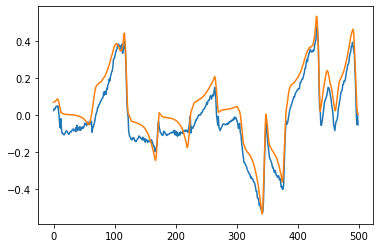

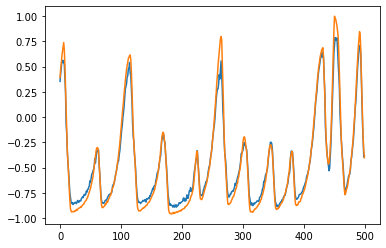

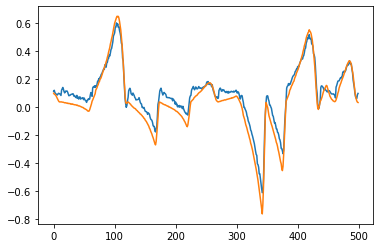

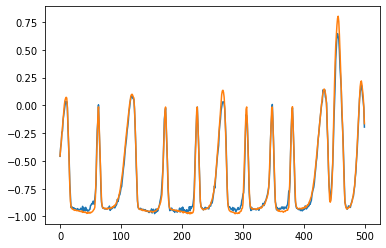

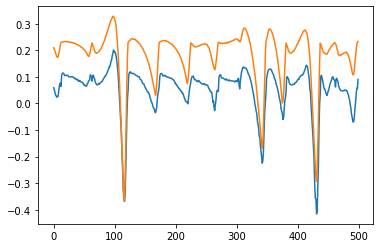

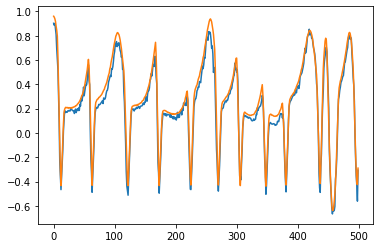

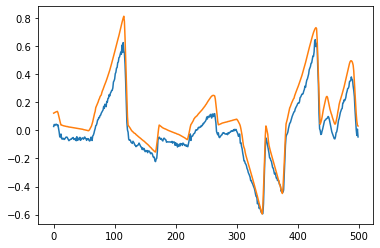

In [125]:
print(RMSE_List[RMSE_List.index(min(RMSE_List))])

labels = Label_List[(RMSE_List.index(min(RMSE_List)))]
predictions = Prediction_List[(RMSE_List.index(min(RMSE_List)))]

# Error promedio de cada una de las articulaciones
joint_error = np.zeros(7)
minimo = np.zeros(7)
maximo = np.zeros(7)
for i in range(7):
    joint_error[i] = sqrt(sklearn.metrics.mean_squared_error(predictions[:, i], labels[:, i]))
    minimo[i] = min(labels[:, i])
    maximo[i] = max(labels[:, i])
    
print(joint_error)

for i in range(7):
    print("Articulacion " + str(i) + " [" + str(round(minimo[i], 2)) + " - " + str(round(maximo[i], 2)) + "] " +
          str(round(abs(round(minimo[i], 2) - round(maximo[i], 2)),2))
          , str(round(joint_error[i]*100/round(abs(round(minimo[i], 2) - round(maximo[i], 2)),2),2)) + "%")
    
    
for i in range(7):
    plt.plot(predictions[500:1000, i], label='prediction')
    plt.plot(labels[500:1000, i], label='target')
    plt.show()

## Print the Results

In [ ]:
print(os.getcwd())
observaciones=fnmatch.filter(os.listdir('Test_dataset'), '*.csv')

ordenado=[]
for i in observaciones:
    if i.split(".")[0].split("_")[1]!="Actions":
        ordenado.append(int(i.split(".")[0].split("_")[1]))
ordenado=sorted(ordenado)
        
tamPruebas=[0]
j=0
for observacion in ordenado:
    observacion="0_"+str(observacion)+".csv"
    tam=len(pd.read_csv("Test_dataset/"+str(observacion)))
    j+=tam
    tamPruebas.append(j)
    
print(tamPruebas)

In [ ]:
#MSE por demostracion
mseDem=[]
rmseDem=[]
for j in range(len(tamPruebas)-1):
    mseDem.append(sklearn.metrics.mean_squared_error(labels[tamPruebas[j]:tamPruebas[j+1]], predictions[tamPruebas[j]:tamPruebas[j+1]]))
    rmseDem.append(sqrt(mseDem[i]))
print("Los valores del error cudratico medios (MSE) por demostracion son igual a "+str(mseDem[0:5]))
print("Los valores RMSE por demostracion son igual a "+str(rmseDem[0:5]))
print("El valor maximo de MSE es "+str(max(mseDem))+" y equivale a la prueba "+str(np.argmax(mseDem)))
print("El valor medio de MSE es "+str(np.mean(mseDem)))

In [ ]:
import matplotlib.pyplot as plt
# Ploteo las comparaciones de las predicciones con los labels
#for j in range(len(tamPruebas)-1):
for j in range(3):
    print("MSE:",sklearn.metrics.mean_squared_error(labels[tamPruebas[j]:tamPruebas[j+1]], predictions[tamPruebas[j]:tamPruebas[j+1]]))
    for i in range(7):
        plt.plot(predictions[tamPruebas[j]:tamPruebas[j+1], i], label='prediction')
        plt.plot(labels[tamPruebas[j]:tamPruebas[j+1], i], label='target')
        plt.title("Observacion: " + str(j+1) +" - Articulacion " + str(i+1))
        plt.show()

## Save the Model

In [126]:
print(Epoch_List[(RMSE_List.index(min(RMSE_List)))])
print(Model_List[(RMSE_List.index(min(RMSE_List)))])
torch.save(Model_List[(RMSE_List.index(min(RMSE_List)))], 'model_pytorch_00859')
model = torch.load('model_pytorch_00859')
model.eval()

12
MultiImage(
  (fe): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

MultiImage(
  (fe): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 